# Self-learning machine with an array of nonlinear cavities with fabrication imperfections

Copyright 2022, Victor Lopez-pastor, Florian Marquardt, MIT License.

In [3]:
import numpy as np

import eqs_motion as eom            # the equations of motion are encoded here
import SplitFourier as SF           # this module uses the split Fourier method to solve the eqs. of motion
import HEB                          # this module implements the HEB procedure
import datasets as ds               # the datasets used to train are generated here
import encoding_realspace as enc    # this module implements the encoding of the Psi, Theta fields in the global Phi field
                                  

from matplotlib import pyplot as plt

In this notebook we test HEB for an array of superconducting cavities. Each cavity is nonlinear (Kerr nonlinearity). The cavities are conceptually divided in two groups that represent $\Psi$ and $\Theta$. The cavities are arranged in a 2d square lattice with nearest neighbour connectivity. 

In the simplest case, the one that we contemplate here, one row of the square lattice represents $\Psi$ while the remaining cavities corresponds to $\Theta$.

The fields $\Psi$ and $\Theta$ are encoded in the global field $\Phi$. All the functions that solve the numerical equations, and the module where the equations of motion are written, takes as input $\Phi$. In order to study other equations of motion, one only needs to modify the module eqs_motion. If one wants to change the way that $\Psi$ and $\Theta$ are encoded in $\Phi$, one just needs to modify encoding_realspace.

This code can be used to simulate several trajectories in parallel (for example if one wants to explore the effect of the intensity of the fields on the learning accuracy). The array that contains $\Phi$ is indexed as follows: 
       Phi[x,y,trajectory,time].

We have chosen the parameters $g$ and $J$ so that the overal nonlinear phase shift is large enough $(gI>2\pi)$, and at the same time the typical frequency of the lattice modes is larger than the characteristic frequency asociated to the nonlinear terms  (in this case and with  the units employed, $gI\ll J$).

In this notebook we include the effect of disorder. Each cavity has a random frequency shift, drawn from a Gaussian distribution centered around 0 and standard deviation given by $\sigma_\Delta$. We simulate training of such imperfect devices for several values of $\sigma_\Delta$.

In [200]:
# dimensions

width = 4    # width of the lattice

N_psi = 1   # number of rows of cavities that are used to encode Psi


# nonlinearity

g = - 1.0e0




# coupling matrix: fully connected

J = 1e1


# random frequency shifts

M = 20

freq_var = 3.0e-2

freq = np.random.randn(width,width,M)*(np.linspace(0,freq_var,M)[np.newaxis,np.newaxis,:])


# collect all parameters in a single array


params = [g,J,freq]

In [201]:
# duration of the forward step

T = 2.0e1


# number of RK4 steps

N_steps = 2000


# duration of each RK4 step

dt = T/N_steps

In [202]:
# initalization

[Psi_in,Theta_in,target] = ds.input_fields(width,N_psi,M)



In [203]:
# forward evolution

[Psi,Theta] = SF.evolve(Psi_in,Theta_in,params,dt,N_steps)

Here we check that the Hamiltonian is a constant of motion to a reasonable numerical accuracy. This is important to ensure that the step size has beeen chosen adequately and that the equations of motion are properly set up.

(4, 4, 20, 2000)
(20, 2000)


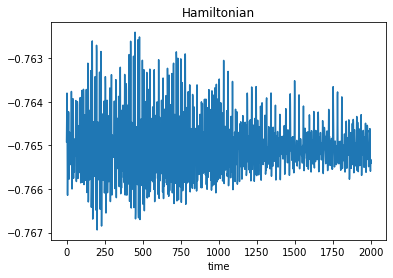

In [204]:
# check that the Hamiltonian is a constant of motion


k = 0

traj_index = M-1


Phi = enc.encode(Psi,Theta)    # the outcome of SF.evolve is [Psi,Theta], but we chose that the 

H = eom.Hamiltonian(Phi,params)

plt.plot(H[traj_index,:])

plt.title('Hamiltonian')

plt.xlabel('time')

plt.show()

Now we compare the update given by HEB to a numerical estimation of the gradient (by means of the finite difference method).
We use two variants of HEB, the 'simple HEB' and the 'averaged HEB'. 
The simple HEB consists of an echo step followed by a decay step.
The averaged HEB is composed of two simple HEB steps. In the first simple HEB step we choose $\eta_1,m_1>0$ ($\eta$ is the amplitude of the injected error signal, and $m$ is the effective mass of the decay step);  in the second we choose $\eta_2=-\eta_1,m_2=-m_1$. In this way we can cancel out the unwanted bias due to a non-zero value of the gradient of the cost function with respect to the momentum of the learning variables. Note that from the point of vieew of the experimental implementation the averaged HEB does not require more resources than the simple HEB.

We can observe that while  the simple HEB fails for small values of the effective mass $m$, the averaged HEB method remains accurate. Therefore, we use the averaged HEB in the following. 

In [205]:
# Check that HEB performs SGD

amp_psi = 0.8*np.ones(M)    # We simulate 'M' different trajectories in parallel:
                                    # psi_amp is the initial amplitude of each of Psi for each of the trajectories.
                                    # This way we can study the effect of the intensity on the accuracy


[Psi_in,Theta_in,target] = ds.XOR_fields(width,N_psi,M,amp_psi)



eta = 1.0e-4

loss = 1e2

m = 1.0e-1


In [206]:
j = 1



[Psi_in_1,Theta_in_1,cost] = HEB.HEB_step(Psi_in[:,:,j,:],Theta_in,params,dt,N_steps,target[j,:],eta,loss,m)


[Psi_in_2,Theta_in_2,cost] = HEB.HEB_step_av(Psi_in[:,:,j,:],Theta_in,params,dt,N_steps,target[j,:],eta,loss,m)




[x,y] = [1,2]

h = 1e-5

[dC_fd,meanC] = HEB.grad_C_fd(Psi_in[:,:,j,:],Theta_in,params,dt,N_steps,target[j,:],eta,x,y,h)



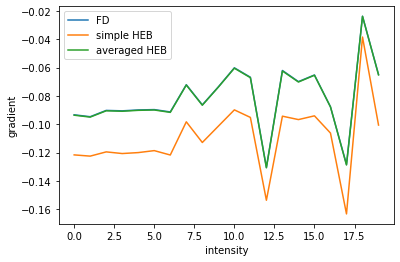

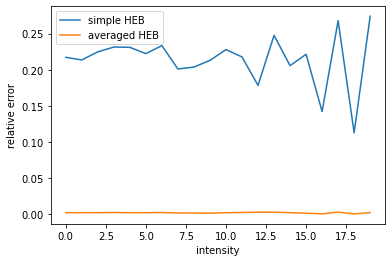

In [207]:
dC = -2*m/eta*( Theta_in_1 - Theta_in )

dC_av = -m/eta*( Theta_in_2 - Theta_in )




plt.plot(dC_fd, label='FD')

plt.plot(np.real(dC[x,y]), label='simple HEB')

plt.plot(np.real(dC_av[x,y]), label='averaged HEB')

plt.legend()

plt.ylabel('gradient')

plt.xlabel('intensity')

plt.show()



plt.plot(np.abs(dC[x,y]-dC_fd)/np.max(np.abs(dC_fd)), label='simple HEB')

plt.plot(np.abs(dC_av[x,y]-dC_fd)/np.max(np.abs(dC_fd)), label='averaged HEB')

plt.legend()

plt.ylabel('relative error')

plt.xlabel('intensity')

plt.show()

Finally we simulate the learning of the XOR logical set. The function ds.XOR_fields generates the dataset. The input is given by two of the $\Psi$ modes and the output is given by a third one. We simulate the learning proccess for $M$ trajectories in parallel, each one with a different intensity for $\Psi$.

In [208]:
#amp_psi = np.linspace(0.8,1.5,M)
amp_psi = 1.0*np.ones(M)


[Psi_in,Theta_in,target] = ds.XOR_fields(width,N_psi,M,amp_psi)




In [209]:
s = 0


In [210]:
# optimization loop

eta = 1.0e-4

loss = 1e2

m = 1.0/1.0e3

N_train = 500




[Theta_in,cost] = HEB.optimization_av(Psi_in,Theta_in,params,dt,N_steps,target,eta,loss,m,N_train)

100%|██████████| 500/500 [1:09:25<00:00,  8.33s/it]    


In [211]:
if(s>0):

    cost_t = np.concatenate([cost_t,cost],axis=0)

else:
    
    cost_t = cost
    
    s = 1


# Cost function over time #

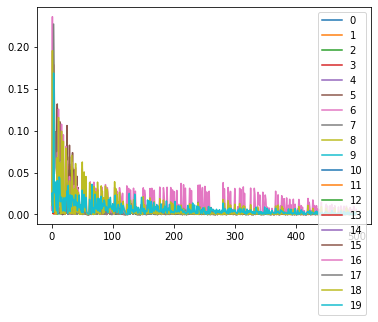

In [212]:
for j in range(0,M):

    plt.plot(cost_t[:,j],label=str(j))

plt.legend()
    
plt.show()


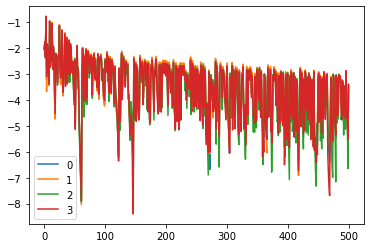

In [213]:
for j in range(0,4):

    plt.plot(np.log10(cost_t[:,j]),label=str(j))

plt.legend()
    
plt.show()

We print the output compared with the target.

In [198]:
outputs = np.zeros((M,4))

for j in range(0,4): 
    
    [Psi_out,Theta_out] = SF.output_SLM(Psi_in[:,:,j,:],Theta_in,params,dt,N_steps)
    
    outputs[:,j] = np.real(Psi_out[0,-1,:])
    
    #for traj_index in range(m1,m2):

        #print('output =  ', Psi_out[0,-1,traj_index] )

        #print('target =  ', target[j,traj_index], '\n')
        
    


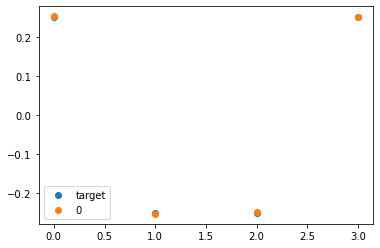

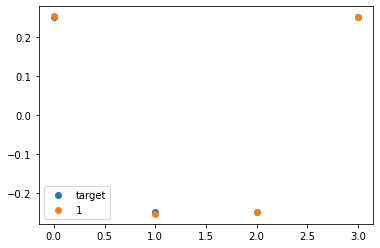

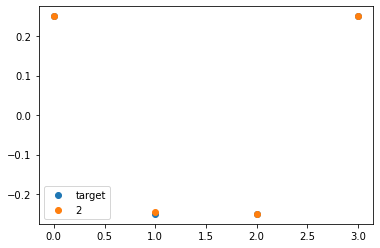

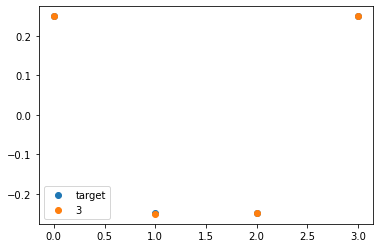

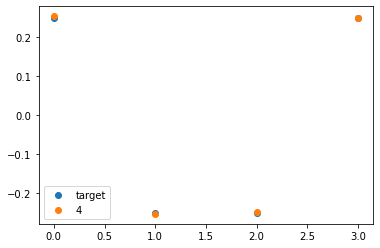

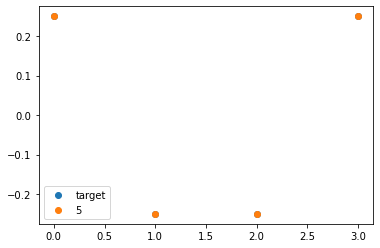

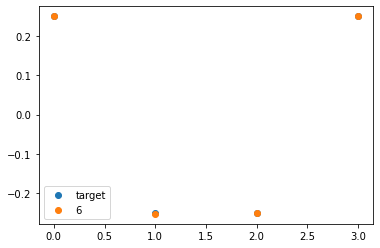

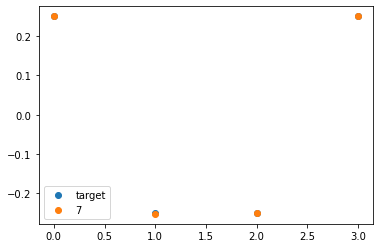

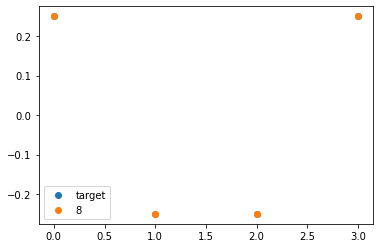

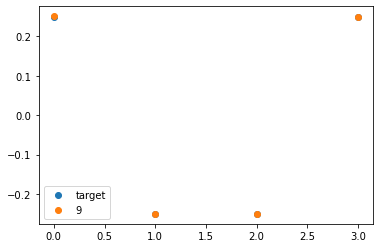

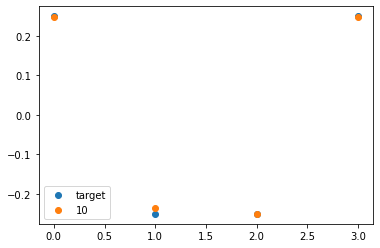

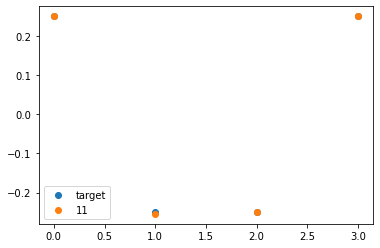

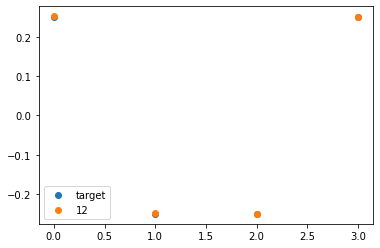

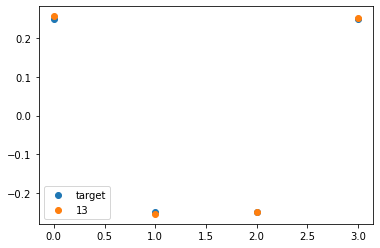

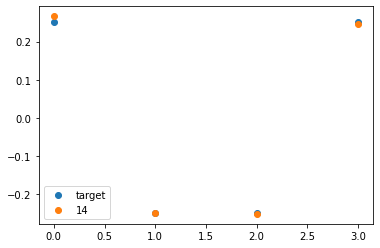

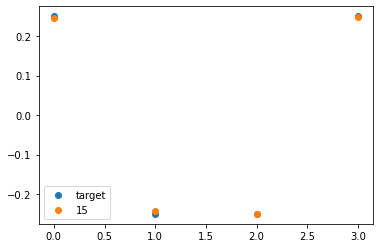

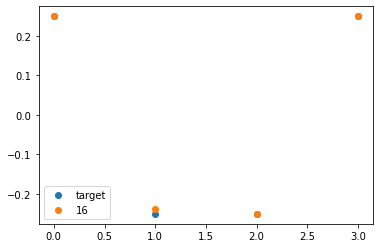

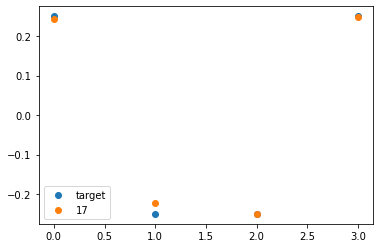

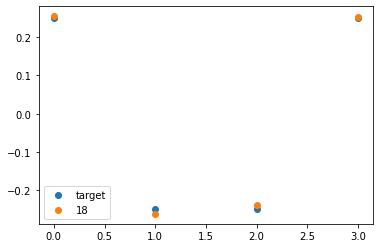

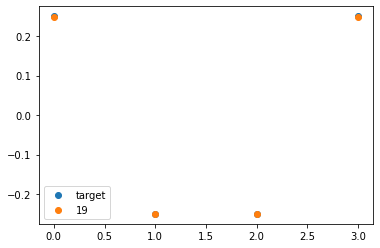

In [199]:
[m1,m2] = [0,M]    



for traj_index in range(m1,m2):
    
    plt.scatter(np.arange(0,4),np.real(target[:,traj_index]),label = 'target')
    
    plt.scatter(np.arange(0,4),outputs[traj_index,:],label=str(traj_index))

    plt.legend()    
    
    plt.show()